This notebook is based on data from magnav challenge and is trying to come with a solution to it.

# Import packages

In [92]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import random
from ipyleaflet import Map, LocalTileLayer, Polyline, LegendControl, ScaleControl
from ipywidgets import Layout
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import time
import datetime
from scipy import signal
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from anomaly_maps import ChallMagMap
import ppigrf
import magnav

In [2]:
# from importlib import reload
# magnav = reload(magnav)
# ppigrf = reload(ppigrf)

# 0 - Dataset informations

In [3]:
# Extract ampling frequency, duration and number of data collected from the dataset

for n in range(2,6):
    
    df    = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt100{n}')
    lines = df.LINE.unique()

    total_duration  = 0
    total_data      = 0
    total_freq_samp = 0

    for l in lines :

        df_lines = pd.DataFrame()
        mask     = (df.LINE == l)
        df_lines = pd.concat([df_lines,df.loc[mask]],axis=0)

        freq_samp = magnav.sampling_frequency(df_lines)
        duration  = df_lines.index[-1]-df_lines.index[0]
        nb_data   = np.shape(df_lines)[0]

        total_duration  += duration
        total_data      += np.shape(df_lines)[0]
        total_freq_samp += freq_samp/len(lines)
        total_lines      = len(lines)

        #print(f"{l} : Sampling frequency = {freq_samp:.2f}Hz, Duration = {to_hms(duration)}, Number of data collected = {nb_data}")

    print(f'Flight : 100{n} | Total flight time : {magnav.to_hms(total_duration)} | Number of data collected : {total_data} | Sampling frequency : {total_freq_samp:.2f}Hz | Number of unique flight lines : {total_lines}')

del df,lines,df_lines,mask

Flight : 1002 | Total flight time : 05h:45m:55s | Number of data collected : 207578 | Sampling frequency : 10.00Hz | Number of unique flight lines : 28
Flight : 1003 | Total flight time : 04h:26m:42s | Number of data collected : 160030 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10
Flight : 1004 | Total flight time : 02h:15m:38s | Number of data collected : 81408 | Sampling frequency : 10.00Hz | Number of unique flight lines : 21
Flight : 1005 | Total flight time : 02h:16m:12s | Number of data collected : 81731 | Sampling frequency : 10.00Hz | Number of unique flight lines : 10


# 1 - Import flight data

## 1.1 - Select the flight number

In [4]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5)],
    value=3,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=1, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5))…

## 1.2 - Select the lines of the flight

In [96]:
# Load data from the flight selected above

df = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt100{w_flight.value}')

In [97]:
# Create a widget to select the line(s) of the selected flight

w_lines = widgets.SelectMultiple(
    options     = df.LINE.unique(),
    description = 'Select line(s):',
    disabled    = False)
display(w_lines)

SelectMultiple(description='Select line(s):', options=(1003.01, 1003.02, 1003.03, 1003.04, 1003.05, 1003.06, 1…

## 1.3 - Load the selected line(s) data of a specific flight

In [99]:
# Extracting selcted line(s) from the dataset

df_lines = pd.DataFrame()
for line in w_lines.value:
    mask     = (df.LINE == line)
    df_lines = pd.concat([df_lines,df.loc[mask]],axis=0)

duration = df_lines.index[-1]-df_lines.index[0]

print(f'Rows : {np.shape(df_lines)[0]} | Columns : {np.shape(df_lines)[1]} | Duration : {magnav.to_hms(duration)}\n')
df_lines.head()

Rows : 101065 | Columns : 92 | Duration : 02h:48m:26s



,MSL_Z,NORM_ACC,BARO,CUR_ACHi,CUR_ACLo,CUR_ACPWR,CUR_BAT1,CUR_BAT2,CUR_COM1,CUR_FLAP,...,V_BLOCK,V_CABT,V_FAN,V_GYRO1,V_GYRO2,V_OUTPWR,V_RESn,V_RESp,V_SERVO,YAWRT
Time [s],,,,,,,,,,,,,,,,,,,,,
49820.0,223.54,0.010,229.39,3.047,2.485,24.919,0.057,0.050,2.514,2.469,...,28.165,26.210,48.284,50.474,27.264,26.334,-47.605,48.159,47.625,0.84
49820.1,223.84,-0.005,229.64,3.042,2.484,24.869,0.059,0.052,2.517,2.469,...,28.177,26.169,48.281,50.469,27.221,26.411,-47.593,48.159,47.620,0.92
49820.2,224.13,-0.008,229.90,3.055,2.484,25.576,0.059,0.051,2.518,2.469,...,28.170,26.022,48.291,50.469,27.214,26.360,-47.597,48.169,47.605,1.06
49820.3,224.43,-0.012,230.15,3.057,2.484,26.598,0.059,0.048,2.514,2.469,...,28.154,25.839,48.281,50.466,27.232,26.255,-47.597,48.196,47.588,1.06
49820.4,224.72,-0.017,230.41,3.036,2.484,27.844,0.056,0.044,2.517,2.468,...,28.154,25.731,48.286,50.464,27.227,26.120,-47.575,48.196,47.564,1.06


# 2 - Data visualization

## 2.1 - Flight path

### 2.1.1 - Satellite view

In [100]:
m = Map(center   = [45.1278, -75.5120],
        zoom     = 9,
        max_zoom = 12,
        min_zoom = 8,
        layout   = Layout(width='80%',height='700px'))

m.add_layer(LocalTileLayer(path="files/home/nlaoue/projet/MagNav/data/external/tiles/{z}/{x}/{y}.png"))

legend = LegendControl({},name="Legend",position="topright")
step = 10 
for line in w_lines.value:
    color = magnav.get_random_color()
    mask = (df.LINE == line)
    locations = (df
                 .loc[mask,['LAT','LONG']][::step]
                 .values
                 .tolist())
    pline = Polyline(
        locations = locations,
        color     = color,
        fill      = False,
        opacity   = 1)
    m.add_layer(pline)
    legend.add_legend_element(str(line),color)

m.add_control(legend)
m.add_control(ScaleControl(position='bottomleft'))

m

Map(center=[45.1278, -75.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

### 2.1.2 - Magnetic anomaly map

In [9]:
# Load anomaly maps

EasternMap = ChallMagMap('../data/raw/Eastern_2.h5')
RenfrewMap = ChallMagMap('../data/raw/Renfrew_2.h5')
GscMap     = ChallMagMap('../data/external/Canada_MAG_RES_200m.hdf5')
WDMAM      = ChallMagMap('../data/external/map_WDMAM.hdf5')

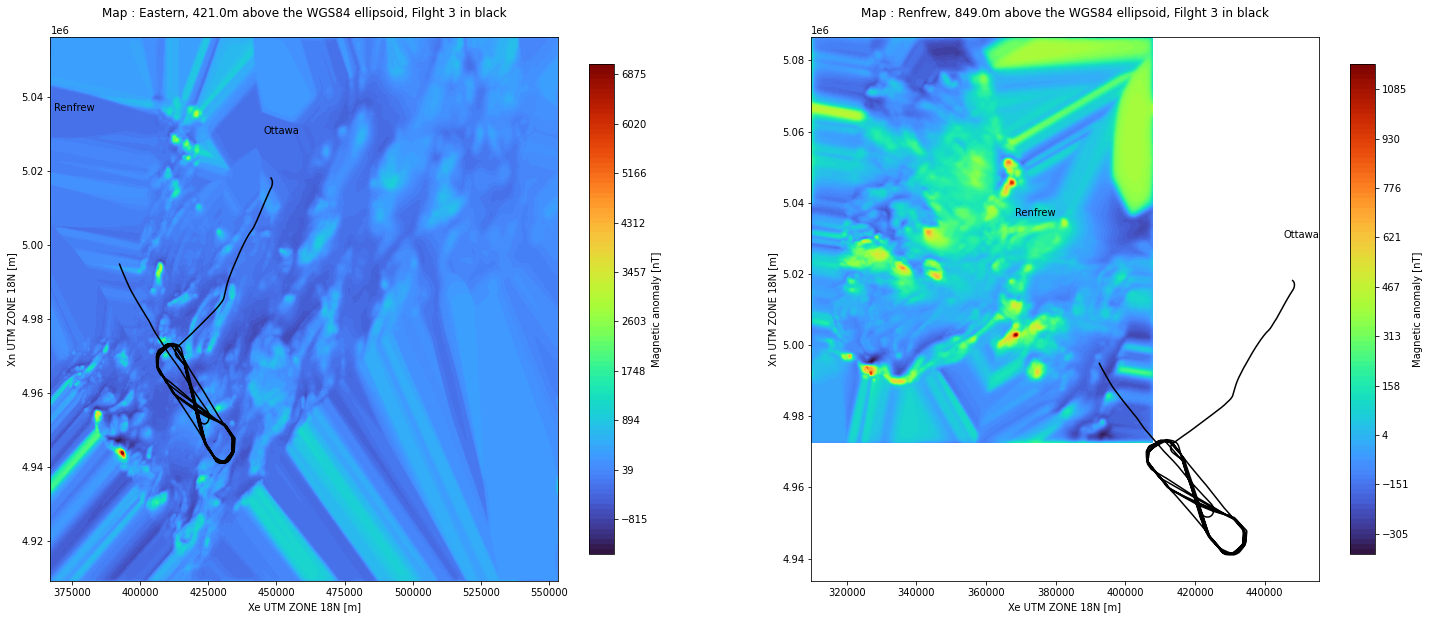

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

df_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = EasternMap.plot(ax1,plot_city=True)
ax1.set_title(f'Map : Eastern, {EasternMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

df_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = RenfrewMap.plot(ax2, plot_city=True)
ax2.set_title(f'Map : Renfrew, {RenfrewMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);

plt.show()

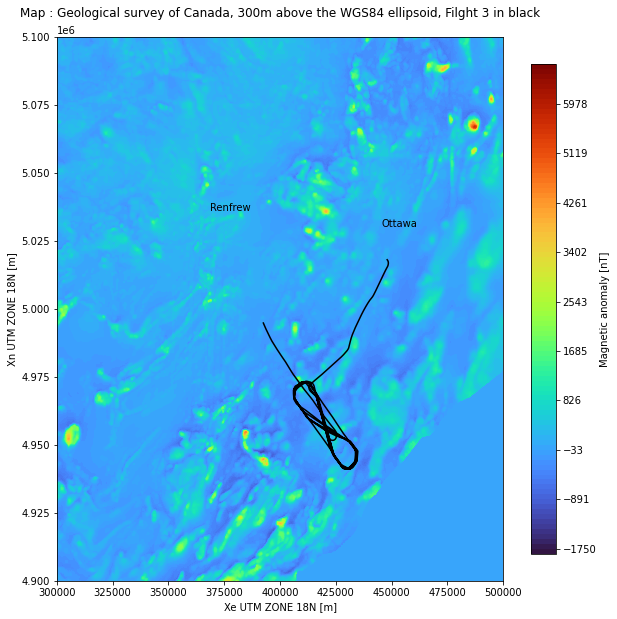

In [11]:
fig, ax = plt.subplots(figsize=[10,10])

df_lines.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax)
ax = GscMap.plot(ax, plot_city=True)
ax.set_title(f'Map : Geological survey of Canada, {GscMap.alt}m above the WGS84 ellipsoid, Filght {w_flight.value} in black',pad=20);
ax.set_xlim(3e5, 5e5)
ax.set_ylim(4.90e6, 5.1e6)

plt.show()

## 2.2 - Events during the flight

In [12]:
line_df = pd.read_csv(f'../data/interim/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-lines.csv')
coms_df = pd.read_csv(f'../data/interim/readmes/Flight_100{w_flight.value}/Flt100{w_flight.value}-comments.csv')

sel_lines_df = pd.DataFrame()
sel_coms_df  = pd.DataFrame()

for n in range(len(w_lines.value)):
    df_concat = line_df.loc[line_df['Line Number'] == w_lines.value[n]]
    sel_lines_df = pd.concat([sel_lines_df,df_concat])

print(sel_lines_df.to_string(index=False),'\n')

for n in range(len(w_lines.value)):
    df_concat = coms_df.loc[coms_df['Line Number'] == w_lines.value[n]]
    sel_coms_df = pd.concat([sel_coms_df,df_concat])

print(sel_coms_df.to_string(index=False))

del line_df, coms_df

 Start Time  End Time  Line Number                Description
    49820.0   50713.0      1003.01 Takeoff - Eastern Free Fly
    50713.0   54497.0      1003.02      Eastern Free Fly 400m
    54497.0   54639.0      1003.03              Climb to 800m
    54639.0   59475.0      1003.04      Eastern Free Fly 800m
    59475.0   59926.0      1003.05            Transit at 800m 

    Time                       Parameter Message  Line Number
50255.97                        WX RADAR ON\\OFF      1003.01
50771.63                             IN BOX AREA      1003.02
50806.38                              POWER LINE      1003.02
50943.57                              POWER LINE      1003.02
51478.22 RADIO 4 MIN AGO. CALL ON COMM 1 & COM 2      1003.02
51599.18                              POWER LINE      1003.02
51680.22                              POWER LINE      1003.02
51751.22                            TRAAIN TRACK      1003.02
52313.19                         LIGHTS BLINKING      1003.02
52473.

## 2.3 - Visualization of magnetic sensors position

There is 2 types of magnetic sensors :
- 5 Scalar magnetometers ~ optically-pumped ,cesium split-beam named Mag 1/2/3/4/5
- 3 Vector fluxgate magnetometers ~ named Flux B/C/D

In [13]:
sel_time = widgets.FloatSlider(
    min  = df_lines.index[0],
    max  = df_lines.index[-1],
    step = 0.1,
    readout_format    = '.1f',
    continuous_update = True
)
print('Select the time to display the direction of the scalar magnetometers : ')
display(sel_time)

Select the time to display the direction of the scalar magnetometers : 


FloatSlider(value=49820.0, max=59926.0, min=49820.0, readout_format='.1f')

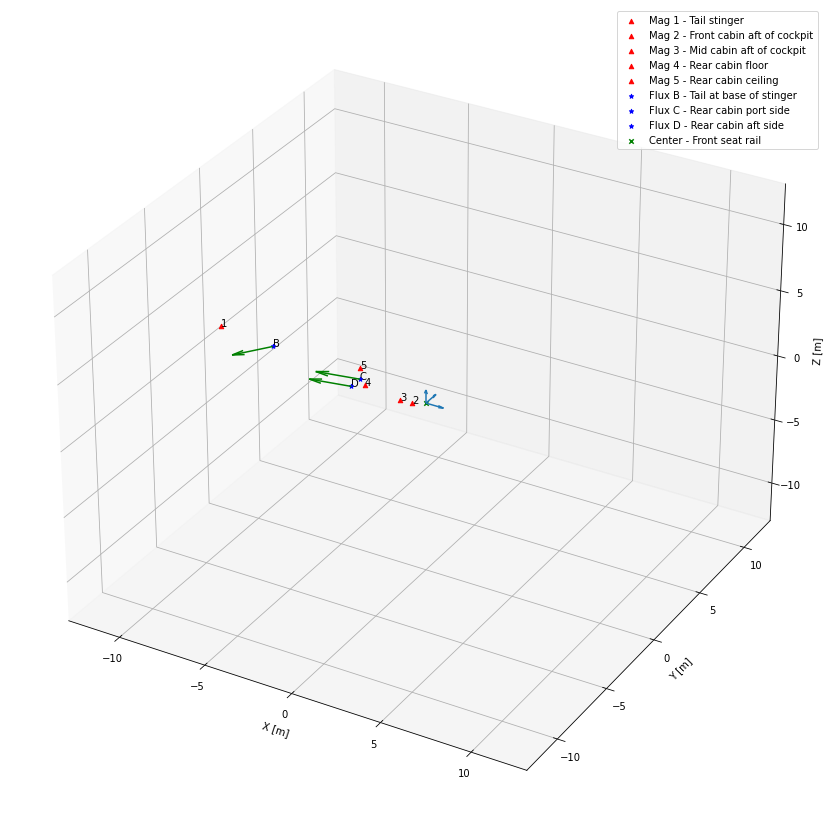

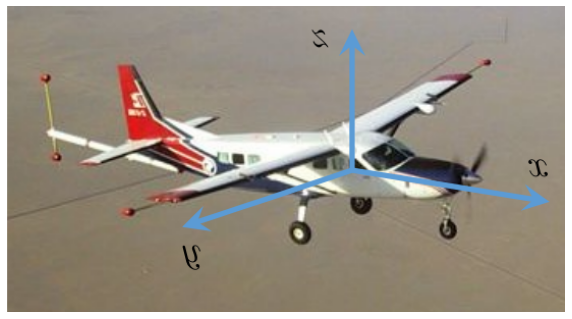

In [66]:
# Scalar magnetometers position
Scal_mag = np.array([[-12.01,0,1.37],
                    [-0.60,-0.36,0],
                    [-1.28,-0.36,0],
                    [-3.53,0,0],
                    [-3.79,0,1.20]])

# Vector magnetometers position
Vect_mag = np.array([[-8.92,0,0.96],
                     [-4.06,0.42,0],
                     [-4.06,-0.42,0]])

fig = plt.figure(figsize=[15,15])
ax  = fig.add_subplot(projection='3d')

# Plot scalar magnetometers position
for n in range(5):
    ax.scatter(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],color='red',marker='^')
    ax.text(Scal_mag[n][0],Scal_mag[n][1],Scal_mag[n][2],str(n+1))

# Plot vector magnetometers position
for n in range(3):
    name = ['B','C','D']
    ax.scatter(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],color='blue',marker='*')
    ax.text(Vect_mag[n][0],Vect_mag[n][1],Vect_mag[n][2],name[n])

# Origin
ax.scatter(0,0,0,color='green',marker='x')
ax.text(0,0,0,'')

# Origin arrows
ax.quiver(0,0,0,1,0,0) # x arrow
ax.quiver(0,0,0,0,1,0) # y arrow
ax.quiver(0,0,0,0,0,1) # z arrow

# Mag vectors direction
scale_factor = 0.00004
ax.quiver(-8.92,0,0.96,
          -scale_factor*df_lines.loc[sel_time.value,'FLUXB_X'],
          -scale_factor*df_lines.loc[sel_time.value,'FLUXB_Y'],
          -scale_factor*df_lines.loc[sel_time.value,'FLUXB_Z'],color='green')

ax.quiver(-4.06,0.42,0,
          scale_factor*df_lines.loc[sel_time.value,'FLUXC_X'],
          scale_factor*df_lines.loc[sel_time.value,'FLUXC_Y'],
          scale_factor*df_lines.loc[sel_time.value,'FLUXC_Z'],color='green')

ax.quiver(-4.06,-0.42,0,
          scale_factor*df_lines.loc[sel_time.value,'FLUXD_X'],
          scale_factor*df_lines.loc[sel_time.value,'FLUXD_Y'],
          scale_factor*df_lines.loc[sel_time.value,'FLUXD_Z'],color='green')


# Legend and labels
ax.legend(['Mag 1 - Tail stinger', 'Mag 2 - Front cabin aft of cockpit', 'Mag 3 - Mid cabin aft of cockpit', 'Mag 4 - Rear cabin floor','Mag 5 - Rear cabin ceiling',
           'Flux B - Tail at base of stinger','Flux C - Rear cabin port side','Flux D - Rear cabin aft side',
           'Center - Front seat rail'])
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# Axes limit
ax.axes.set_xlim3d(left=-12.5, right=12.5)
ax.axes.set_ylim3d(bottom=-12.5, top=12.5)
ax.axes.set_zlim3d(bottom=-12.5, top=12.5)

plt.show()

# Plot image
fig, ax = plt.subplots(figsize=[10,10])
img = image.imread('../data/external/Images/plane_coordinates.png')
ax.imshow(img)
ax.invert_xaxis()

# Remove axes
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## 2.4 - Target data from magnetic anomaly map

There is 2 way to get truth data :
- Compensated data from tail stinger magnetometer
- Magnetic anomaly map

Using tail stinger data is not what we want for this project. We are going to use magnetic anomaly map data. But the quality of the map is really important and low quality map such as "World Magnetic Anomaly Map" may give poor results. Also, we have to interpolate the altitude of the magnetic map to the altitude of the flight, which adds a new processing step.

In [15]:
# Interpolation of anomaly maps
df_lines['GSC_map']     = GscMap.interpolate(df_lines.UTM_X, df_lines.UTM_Y)
df_lines['Eastern_map'] = EasternMap.interpolate(df_lines.UTM_X, df_lines.UTM_Y)
df_lines['Renfrew_map'] = RenfrewMap.interpolate(df_lines.UTM_X, df_lines.UTM_Y)
df_lines['WDMAM_map']   = WDMAM.interpolate(df_lines.UTM_X, df_lines.UTM_Y)

# Remove linear trend
df_lines['IGRFMAG1_detrend'] = signal.detrend(df_lines['IGRFMAG1'])
df_lines['WDMAM_map']        = signal.detrend(df_lines['WDMAM_map'])
df_lines['Eastern_map']      = signal.detrend(df_lines['Eastern_map'])
df_lines['Renfrew_map']      = signal.detrend(df_lines['Renfrew_map'])
df_lines['GSC_map']          = signal.detrend(df_lines['GSC_map'])

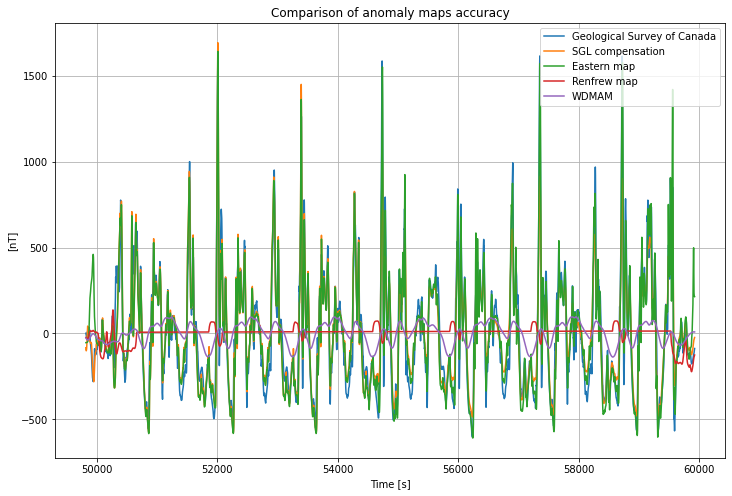


RMSE between SGL compsensation and anomaly map : 
GSC map error = 123.47 nT 
Eastern map error = 91.51 nT 
Renfrew map error = 300.98 nT 
World digital magnetic anomaly map error = 269.51 nT


In [86]:
fig, ax = plt.subplots(figsize=[12,8])

ax.plot(df_lines[['GSC_map','IGRFMAG1_detrend','Eastern_map','Renfrew_map','WDMAM_map']])
ax.legend(['Geological Survey of Canada','SGL compensation','Eastern map','Renfrew map','WDMAM'],loc='upper right')
ax.set_title('Comparison of anomaly maps accuracy')
ax.set_ylabel('[nT]')
ax.set_xlabel('Time [s]')
plt.grid()
plt.show()

# Calculate RMSE between SGL compensation and anomaly maps
GSC_map_rmse     = magnav.rmse(df_lines['IGRFMAG1'],df_lines['GSC_map'])
Eastern_map_rmse = magnav.rmse(df_lines['IGRFMAG1_detrend'],df_lines['Eastern_map'])
Renfrew_map_rmse = magnav.rmse(df_lines['IGRFMAG1_detrend'],df_lines['Renfrew_map'])
WDMAM_map_rmse   = magnav.rmse(df_lines['IGRFMAG1_detrend'],df_lines['WDMAM_map'])

print('\nRMSE between SGL compsensation and anomaly map :',
      f'\nGSC map error = {GSC_map_rmse:.2f} nT',
      f'\nEastern map error = {Eastern_map_rmse:.2f} nT',
      f'\nRenfrew map error = {Renfrew_map_rmse:.2f} nT',
      f'\nWorld digital magnetic anomaly map error = {WDMAM_map_rmse:.2f} nT')

As we can see, Eastern/Renfrew maps are performing the best due to their results. GSC map is not far behind, but the WDMAM is performing poorly due to it's low resolution.

## 2.5 - Exploration Dataset

Not all sensors data should be used, because some may potentially lead to inject truth data in the training. Here is the list of data to use :
- IGRFMAG1 ($nT$) ~ Truth, compensation done by SGL
- DIURNAL ($nT$) ~ Measured diurnal
- UNCOMPMAG2/3/4/5 ($nT$) ~ Uncompensated Airborne magnetic field of Mag 2/3/4/5
- FLUXB/C/D_X/Y/Z ($nT$) ~ Fluxgate X/Y/Z-axis of fluxgate magnetometer B/C/D
- INS_ACC_X/Y/Z ($m.s^{-2}$) ~ INS X/Y/Z acceleration
- PITCH ($nT$) ~ INS computed aircraft pitch
- ROLL ($nT$) ~ INS computed aircraft roll
- AZIMUTH ($nT$) ~ INS computed aircraft azimuth
- CUR_COM1 ($A$) ~ COM1 aircraft radio current sensor
- CUR_ACHi ($A$) ~ Air conditioner fan high current sensor
- CUR_ACLo ($A$) ~ Air conditioner fan low current sensor
- CUR_TANK ($A$) ~ Cabin fuel pump current sensor
- CUR_FLAP ($A$) ~ Flap motor current sensor
- CUR_STRB ($A$) ~ Strobe lights current sensor
- CUR_SRVO_O ($A$) ~ INS Outer servo current sensor
- CUR_SRVO_M ($A$) ~ INS Middle servo current sensor
- CUR_SRVO_I ($A$) ~ INS Inner servo current sensor
- CUR_IHTR ($A$) ~ INS heater current sensor
- CUR_ACPWR ($A$) ~ Aircraft power current sensor
- CUR_OUTPWR ($A$) ~ System output power current sensor
- CUR_BAT1 ($A$) ~ Battery 1 current sensor
- CUR_BAT2 ($A$) ~ Battery 2 current sensor
- V_ACPWR ($V$) ~ Aircraft power voltage sensor
- V_OUTPWR ($V$) ~ System output power voltage sensor
- V_BAT1 ($V$) ~ Battery 1 voltage sensor
- V_BAT2 ($V$) ~ Battery 2 voltage sensor
- V_RESp ($V$) ~ Resolver board positive voltage sensor
- V_RESN ($V$) ~ Resolver board negative voltage sensor
- V_BACKp ($V$) ~ Backplane positive voltage sensor
- V_BACKn ($V$) ~ Backplane negative voltage sensor
- V_GYRO1 ($V$) ~ Gyro 1 voltage sensor
- V_GYRO2 ($V$) ~ Gyro 2 voltage sensor
- V_ACCp ($V$) ~ INS accelerometers positive voltage sensor
- V_ACCn ($V$) ~ INS accelerometers negative voltage sensor
- V_BLOCK ($V$) ~ Block voltage sensor
- V_BACK ($V$) ~ Backplane voltage sensor
- V_SERVO ($V$) ~ Servos voltage sensor
- V_CABT ($V$) ~ Cabinet voltage sensor
- V_FAN ($V$) ~ Cooling fan voltage sensor
- gradient(FLUXB_X/Y/Z) ~ gradient of FLUXB
- gradient(FLUXC_X/Y/Z) ~ gradient of FLUXC
- gradient(FLUXD_X/Y/Z) ~ gradient of FLUXD
- gradient(PITCH/ROLL/AZIMUTH) ~ gradient of PITCH, ROLL and AZMUTH

$nT$ = Nano tesla, $m.s^{-2}$ = Acceleration, $A$ = Ampere, $V$ = Volt

### 2.5.1 - Creation of dataset

Droping all potential truth data

In [17]:
data_to_remove = ['UTM_X','UTM_Y','UTM_Z','MSL_Z','LAT','LONG','BARO','RADAR','TOPO','DEM','DRAPE','COMPMAG1','LAGMAG1','DCMAG1',
                  'UNCOMPMAG1','OGS_MAG','OGS_HGT','INS_WANDER','INS_LAT','INS_LON','INS_HGT','INS_VEL_N','INS_VEL_W','INS_VEL_V',
                  'PITCHRT','ROLLRT','YAWRT','LONG_ACC','LAT_ACC','NORM_ACC','TRUE_AS','PITOT_P','STATIC_P','TOT_P','FLT','TIME']

df_chall = df.drop(columns=data_to_remove)
df_chall['FLUXB_X'] = -df_chall['FLUXB_X'] # Because FLUXB was not in the right direction
df_chall['FLUXB_Y'] = -df_chall['FLUXB_Y']
df_chall['FLUXB_Z'] = -df_chall['FLUXB_Z']

In [18]:
df_chall['FLUXB_X_grad'] = np.gradient(df_chall['FLUXB_X'])
df_chall['FLUXB_Y_grad'] = np.gradient(df_chall['FLUXB_Y'])
df_chall['FLUXB_Z_grad'] = np.gradient(df_chall['FLUXB_Z'])

df_chall['FLUXC_X_grad'] = np.gradient(df_chall['FLUXC_X'])
df_chall['FLUXC_Y_grad'] = np.gradient(df_chall['FLUXC_Y'])
df_chall['FLUXC_Z_grad'] = np.gradient(df_chall['FLUXC_Z'])

df_chall['FLUXD_X_grad'] = np.gradient(df_chall['FLUXD_X'])
df_chall['FLUXD_Y_grad'] = np.gradient(df_chall['FLUXD_Y'])
df_chall['FLUXD_Z_grad'] = np.gradient(df_chall['FLUXD_Z'])

df_chall['PITCH_grad'] = np.gradient(df_chall['PITCH'])
df_chall['ROLL_grad'] = np.gradient(df_chall['ROLL'])
df_chall['AZIMUTH_grad'] = np.gradient(df_chall['AZIMUTH'])

In [19]:
print('New dataset variables :\n',df_chall.columns.values)

New dataset variables :
 ['CUR_ACHi' 'CUR_ACLo' 'CUR_ACPWR' 'CUR_BAT1' 'CUR_BAT2' 'CUR_COM1'
 'CUR_FLAP' 'CUR_IHTR' 'CUR_OUTPWR' 'CUR_SRVO_I' 'CUR_SRVO_M' 'CUR_SRVO_O'
 'CUR_STRB' 'CUR_TANK' 'DIURNAL' 'FLUXB_TOT' 'FLUXB_X' 'FLUXB_Y' 'FLUXB_Z'
 'FLUXC_TOT' 'FLUXC_X' 'FLUXC_Y' 'FLUXC_Z' 'FLUXD_TOT' 'FLUXD_X' 'FLUXD_Y'
 'FLUXD_Z' 'INS_ACC_X' 'INS_ACC_Y' 'INS_ACC_Z' 'AZIMUTH' 'PITCH' 'ROLL'
 'IGRFMAG1' 'UNCOMPMAG2' 'UNCOMPMAG3' 'UNCOMPMAG4' 'UNCOMPMAG5' 'LINE'
 'V_ACCn' 'V_ACCp' 'V_ACPWR' 'V_BACK' 'V_BACKn' 'V_BACKp' 'V_BAT1'
 'V_BAT2' 'V_BLOCK' 'V_CABT' 'V_FAN' 'V_GYRO1' 'V_GYRO2' 'V_OUTPWR'
 'V_RESn' 'V_RESp' 'V_SERVO' 'FLUXB_X_grad' 'FLUXB_Y_grad' 'FLUXB_Z_grad'
 'FLUXC_X_grad' 'FLUXC_Y_grad' 'FLUXC_Z_grad' 'FLUXD_X_grad'
 'FLUXD_Y_grad' 'FLUXD_Z_grad' 'PITCH_grad' 'ROLL_grad' 'AZIMUTH_grad']


Challenge solution Dataset

# 3 - Data correction

Multiples corrections are applied to the initial data.

## 3.1 - Lag correction

Lag = sensor_offset / aircraft_speed

In [20]:
Lag = 11.18/np.mean(df_lines['TRUE_AS'])
print(f'Lag = {Lag:.2f}')

Lag = 0.17


We approximate lag to 0.2 because we only have an accuracy of 0.1 so we can't apply a lag of 0.17 that need 0.01 accuracy.

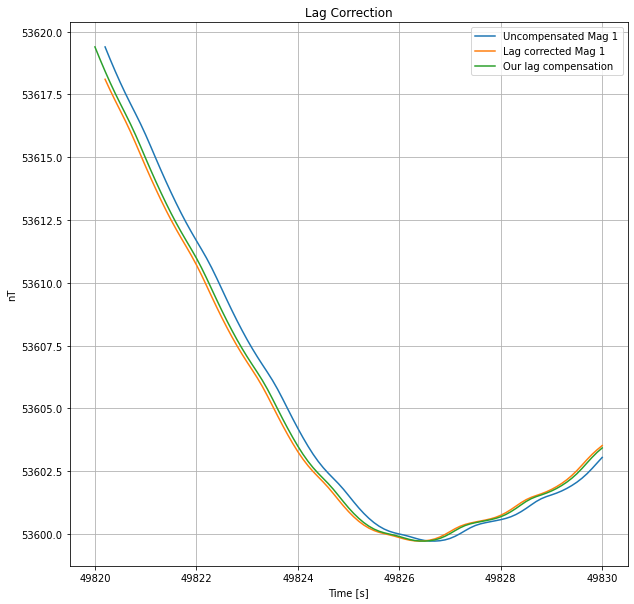


Difference between uncompensated and lag compensated magnetometer values = 2.58 nT

Difference between our and SGL lag compensation = 0.36 nT


In [68]:
lag_rmse          = magnav.rmse(df_lines['LAGMAG1'],df_lines['COMPMAG1'])
our_lag_cor       = df_lines['COMPMAG1'].drop([df_lines.index[0],df_lines.index[1]])
our_lag_cor.index = our_lag_cor.index-0.2
sgl_lag_cor       = df_lines['LAGMAG1'].drop([df_lines.index[-1],df_lines.index[-2]])
our_vs_sgl_lag    = magnav.rmse(our_lag_cor,sgl_lag_cor)

fig, ax = plt.subplots(figsize = [10,10])

ax.plot(df_lines.drop([df_lines.index[0],df_lines.index[1]]).loc[:df_lines.index[0]+10,['COMPMAG1','LAGMAG1']])
ax.plot(our_lag_cor[:df_lines.index[0]+10])
ax.legend(['Uncompensated Mag 1','Lag corrected Mag 1','Our lag compensation'])
ax.set_title('Lag Correction')
ax.set_xlabel('Time [s]')
ax.set_ylabel('[nT]')
plt.grid()
plt.show()

print(f'\nDifference between uncompensated and lag compensated magnetometer values = {lag_rmse:.2f} nT')
print(f'\nDifference between our and SGL lag compensation = {our_vs_sgl_lag:.2f} nT')

## 3.2 - Diurnal correction

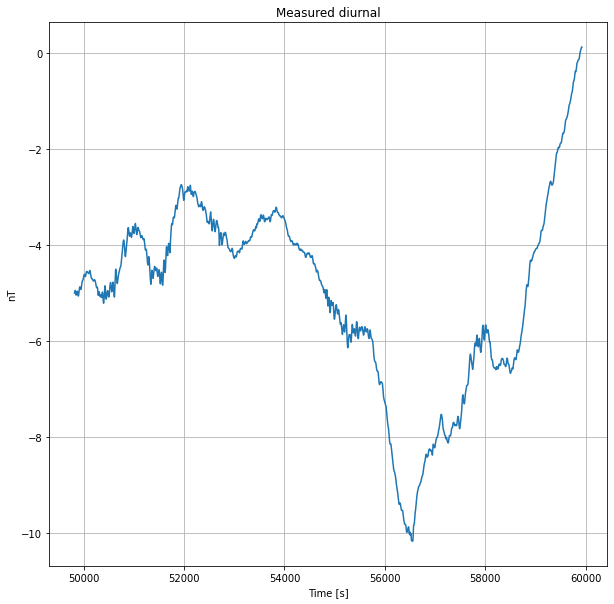

In [69]:
fig, ax = plt.subplots(figsize = [10,10])

ax.plot(df_lines['DIURNAL'])
ax.set_title('Measured diurnal')
ax.set_ylabel('[nT]')
ax.set_xlabel('Time [s]')
plt.grid()
plt.show()

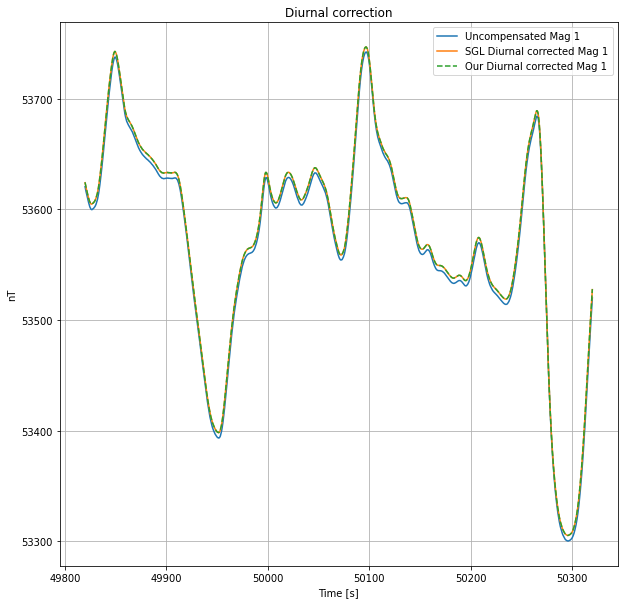


Difference between diurnal+lag compensated and uncompensated magnetometer  = 3.27 nT
Our vs SGL Diurnal compensation = 0.36 nT


In [70]:
diurnal_rmse = magnav.rmse(df_lines['DCMAG1'],df_lines['COMPMAG1'])
our_dc_cor = our_lag_cor-df_lines['DIURNAL'].drop([df_lines.index[0],df_lines.index[1]]).tolist()
our_vs_sgl_diurnal = magnav.rmse(df_lines['DCMAG1'].drop([df_lines.index[-2],df_lines.index[-1]]),our_dc_cor)

fig, ax = plt.subplots(figsize = [10,10])

ax.plot(df_lines[['COMPMAG1','DCMAG1']].loc[:df_lines.index[0]+500])
ax.plot(our_dc_cor.loc[:df_lines.index[0]+500],'--')
ax.legend(['Uncompensated Mag 1','SGL Diurnal corrected Mag 1','Our Diurnal corrected Mag 1'])
ax.set_title('Diurnal correction')
ax.set_ylabel('[nT]')
ax.set_xlabel('Time [s]')
plt.grid()
plt.show()

print(f'\nDifference between diurnal+lag compensated and uncompensated magnetometer  = {diurnal_rmse:.2f} nT')
print(f'Our vs SGL Diurnal compensation = {our_vs_sgl_diurnal:.2f} nT')

Our Diurnal compensation doesn't add any significant error.

## 3.5 - IGRF correction

In [24]:
lat = df_lines['LAT'].drop([df_lines.index[0],df_lines.index[1]])
lon = df_lines['LONG'].drop([df_lines.index[0],df_lines.index[1]])
h = 0.313 # kilometers above WGS84 ellipsoid, no impact on rmse due to low altitude
date = datetime.datetime(2019, 11, 1)

Be, Bn, Bu = ppigrf.igrf(lon,lat,h,date)

our_IGRF_cor = our_dc_cor - np.sqrt(Be**2+Bn**2+Bu**2)[0]

our_vs_true_IGRF = magnav.rmse(df_lines['IGRFMAG1'].drop([df_lines.index[-1],df_lines.index[-2]]),our_IGRF_cor)
uncor_vs_cor_sgl = magnav.rmse(df_lines['IGRFMAG1'],df_lines['COMPMAG1'])
uncor_vs_cor_our = magnav.rmse(our_IGRF_cor,df_lines['COMPMAG1'].drop([df_lines.index[-2],df_lines.index[-1]]))

print(f'Not IGRF corrected vs IGRF corrected mag (SGL) = {uncor_vs_cor_sgl:.2f} nT')
print(f'Not IGRF corrected vs IGRF corrected mag (our) = {uncor_vs_cor_our:.2f} nT')
print(f'Own vs SGL IGRF correction = {our_vs_true_IGRF:.2f} nT')

Not IGRF corrected vs IGRF corrected mag (SGL) = 62.99 nT
Not IGRF corrected vs IGRF corrected mag (our) = 62.65 nT
Own vs SGL IGRF correction = 5.29 nT


5.29 nT error could be due to the height, levelling and micro-leveling corrections that SGL do between diurnal and IGRF correction. 

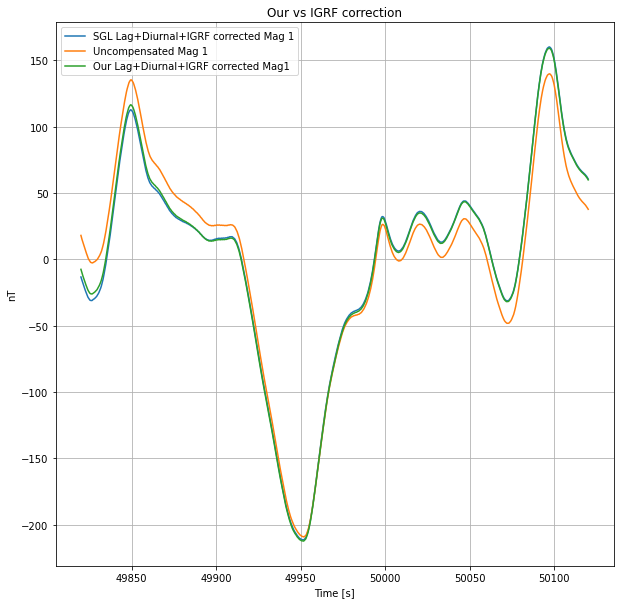

In [71]:
fig, ax = plt.subplots(figsize = [10,10])

ax.plot(df_lines['IGRFMAG1'].loc[:df_lines.index[0]+300]-np.mean(df_lines['IGRFMAG1'].loc[:df_lines.index[0]+300]))
ax.plot(df_lines['COMPMAG1'].drop([df_lines.index[-1],df_lines.index[-2]]).loc[:df_lines.index[0]+300]-np.mean(df_lines['COMPMAG1'].drop([df_lines.index[-1],df_lines.index[-2]]).loc[:df_lines.index[0]+300]))
ax.plot(our_IGRF_cor.loc[:df_lines.index[0]+300]-np.mean(our_IGRF_cor.loc[:df_lines.index[0]+300]))

ax.legend(['SGL Lag+Diurnal+IGRF corrected Mag 1','Uncompensated Mag 1','Our Lag+Diurnal+IGRF corrected Mag1'])
ax.set_title('Our vs IGRF correction')
ax.set_xlabel('Time [s]')
ax.set_ylabel('[nT]')
plt.grid()
plt.show()

# 4 - Tolles-Lawson

## 4.1 - Tolles-Lawson pattern

In [26]:
flight_number = 2
df_pattern    = pd.read_hdf('../data/interim/Flt_data.h5',key=f'Flt100{flight_number}')

mask_1 = (df_pattern.LINE == 1002.02)
mask_2 = (df_pattern.LINE == 1002.20)

tl_sq = df_pattern[mask_1] # Square Tolles-Lawson pattern
tl_cl = df_pattern[mask_2] # Cloverleaf Tolles-Lawson pattern

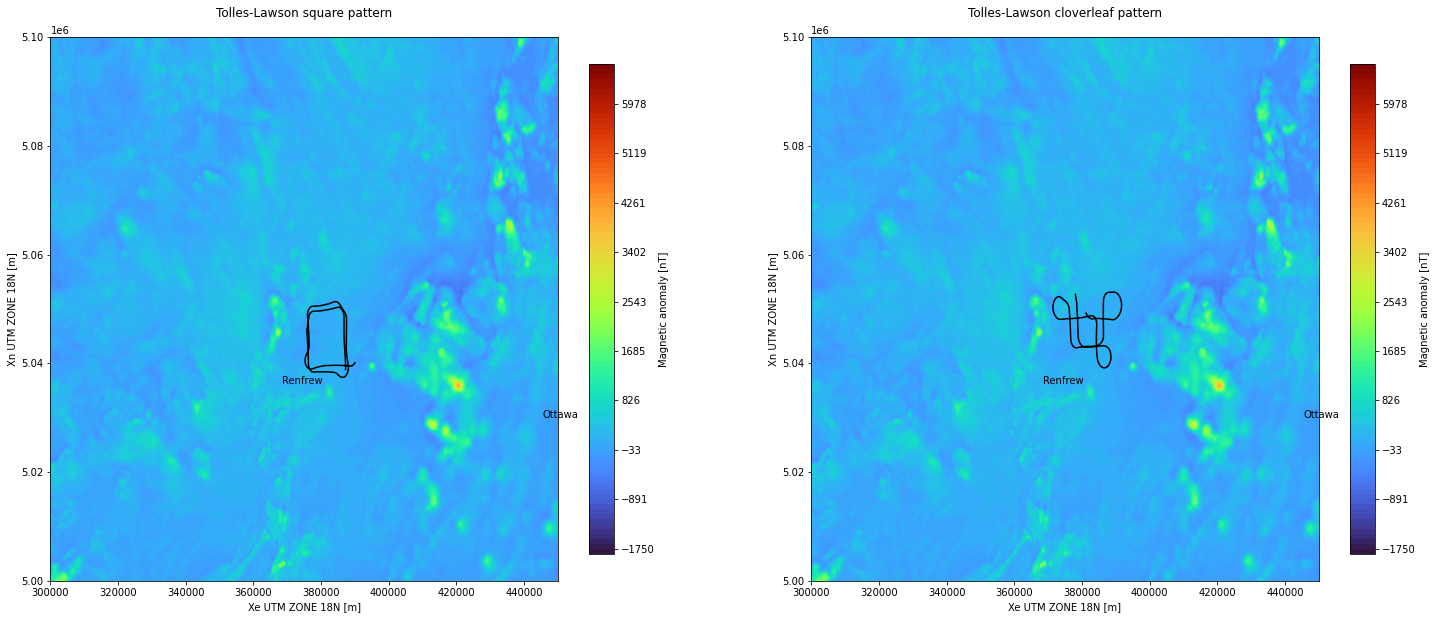

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

tl_sq.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax1)
ax1 = GscMap.plot(ax1,plot_city=True)
ax1.set_title('Tolles-Lawson square pattern',pad=20);
ax1.set_xlim(3e5, 4.5e5)
ax1.set_ylim(5e6, 5.1e6);

tl_cl.plot(x='UTM_X', y='UTM_Y', color='black',legend=False, ax=ax2)
ax2 = GscMap.plot(ax2, plot_city=True)
ax2.set_title('Tolles-Lawson cloverleaf pattern',pad=20);
ax2.set_xlim(3e5, 4.5e5)
ax2.set_ylim(5e6, 5.1e6);

plt.show()

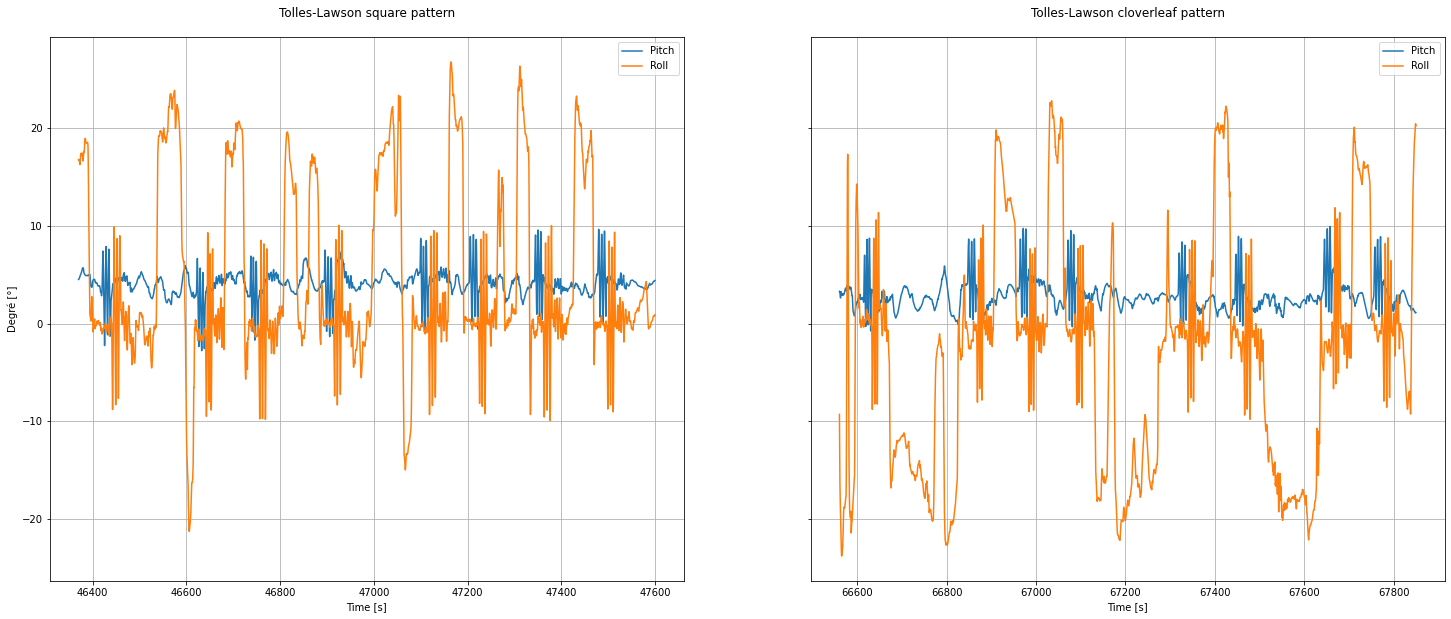

In [80]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=True,figsize=[25,10])

ax1.plot(tl_sq[['PITCH','ROLL']])
ax1.set_title('Tolles-Lawson square pattern',pad=20)
ax1.legend(['Pitch','Roll'])
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Degré [°]')
ax1.grid()

ax2.plot(tl_cl[['PITCH','ROLL']])
ax2.set_title('Tolles-Lawson cloverleaf pattern',pad=20)
ax2.legend(['Pitch','Roll'])
ax2.set_xlabel('Time [s]')
ax2.grid()

plt.show()

## 4.2 - Bandpass filter for Tolles-Lawson calibration

low cut = 0.1 Hz, High cut = 0.9 Hz, sampling frequency = 10 Hz

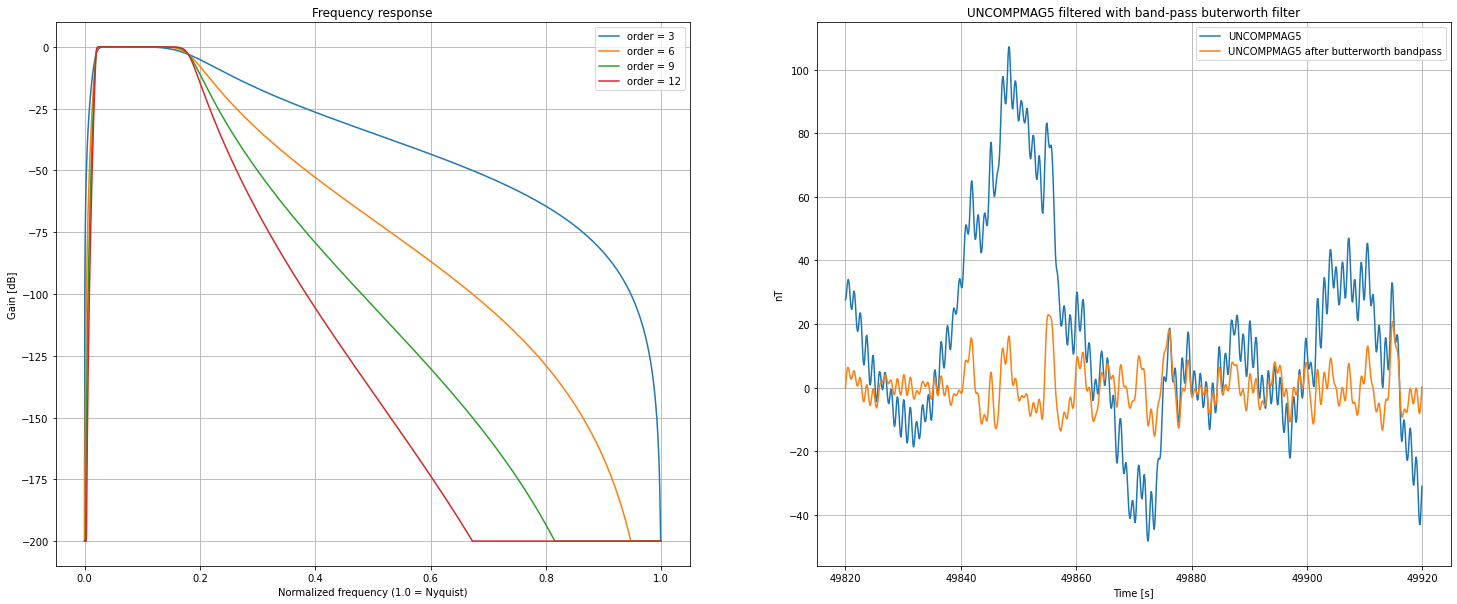

In [81]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9

fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for order in [3,6,9,12]:
    sos  = magnav.create_butter_filter(lowcut,highcut,fs,order=order)
    w, h = signal.sosfreqz(sos,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'order = {order}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.legend()
ax1.grid()

sig = np.array(df_lines['UNCOMPMAG5']-np.mean(df_lines['UNCOMPMAG5']))
plt.plot(df_lines.index[:1000],sig[:1000],label='UNCOMPMAG5')

y = magnav.apply_butter_filter(df_lines['UNCOMPMAG5'],lowcut,highcut,fs,order=4)
ax2.plot(df_lines.index[:1000],y[:1000],label='UNCOMPMAG5 after butterworth bandpass')
ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with band-pass buterworth filter')

plt.show()

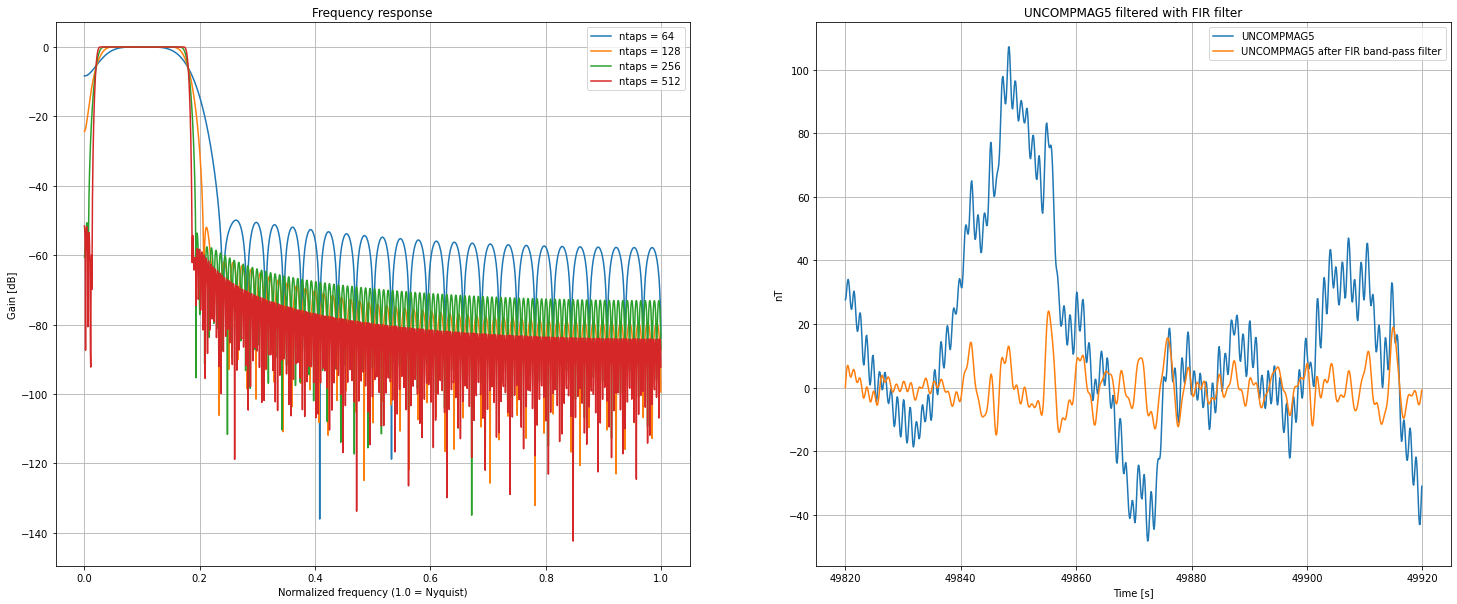

In [90]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=False,sharey=False,figsize=[25,10])

for ntaps in [64,128,256,512]:
    taps_hamming = magnav.create_firwin_filter(lowcut,highcut,fs,ntaps)
    w, h = signal.freqz(taps_hamming,1,worN=2000)
    db = 20*np.log10(np.maximum(np.abs(h),1e-10))
    ax1.plot(w/np.pi,db,label=f'ntaps = {ntaps}')
    
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')
ax1.grid()
ax1.legend()

sig = np.array(df_lines['UNCOMPMAG5']-np.mean(df_lines['UNCOMPMAG5']))
ax2.plot(df_lines.index[:1000],sig[:1000],label='UNCOMPMAG5')

y = magnav.apply_firwin_filter(df_lines['UNCOMPMAG5']-np.mean(df_lines['UNCOMPMAG5']),lowcut,highcut,fs,ntaps=255,window='hamming')
ax2.plot(df_lines.index[:1000],y[:1000],label='UNCOMPMAG5 after FIR band-pass filter')
ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('nT')
ax2.legend()
ax2.set_title('UNCOMPMAG5 filtered with FIR filter')

plt.show()

## 4.3 - Tolles-Lawson coefficients

### 4.3.1 - Square pattern

In [31]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG1'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG2'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG3'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG4'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_sq['FLUXB_X'],tl_sq['FLUXB_Y'],tl_sq['FLUXB_Z'],tl_sq['UNCOMPMAG5'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_chall['FLUXB_X'],df_chall['FLUXB_Y'],df_chall['FLUXB_Z'])

# Correct magnetometers measurements
TL_comp_mag1_sq = np.reshape(df['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_chall['TL_comp_mag2_sq'] = np.reshape(df_chall['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_chall['TL_comp_mag3_sq'] = np.reshape(df_chall['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_chall['TL_comp_mag4_sq'] = np.reshape(df_chall['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_chall['TL_comp_mag5_sq'] = np.reshape(df_chall['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

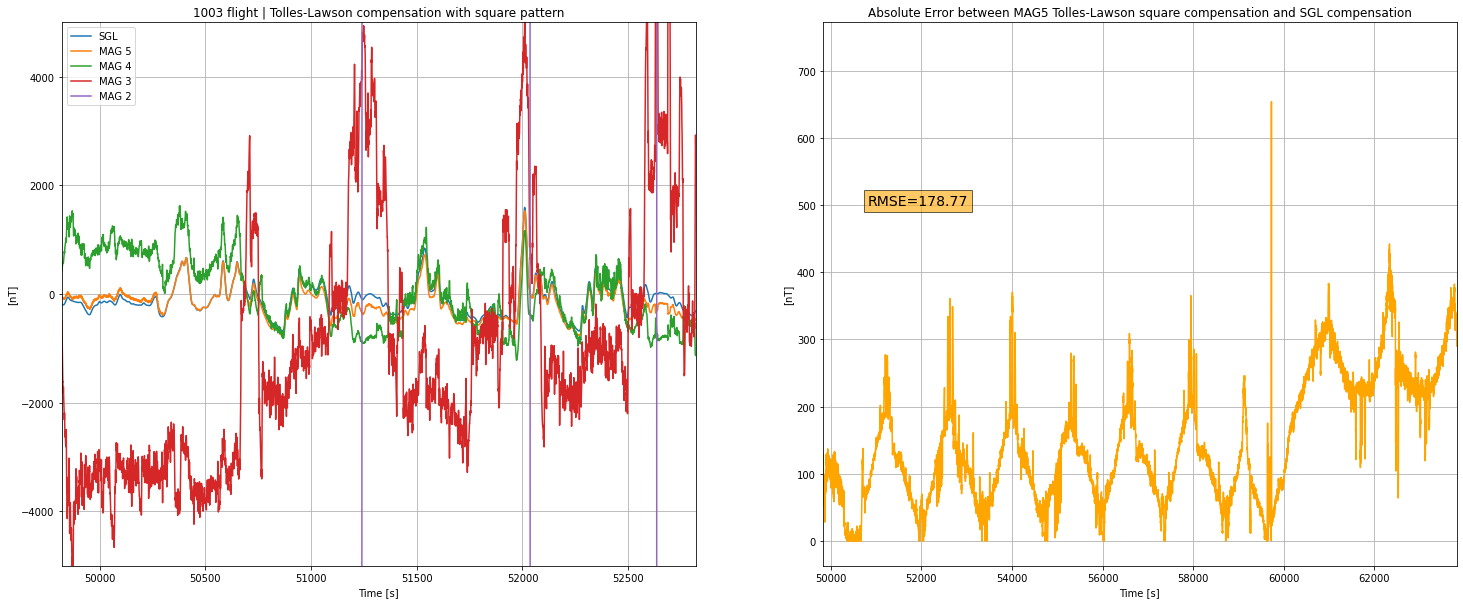

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[25,10])

ax1.plot(df_chall['IGRFMAG1'],label='SGL')
ax1.plot(df_chall['TL_comp_mag5_sq']-np.mean(df_chall['TL_comp_mag5_sq']),label='MAG 5')
ax1.plot(df_chall['TL_comp_mag4_sq']-np.mean(df_chall['TL_comp_mag4_sq']),label='MAG 4')
ax1.plot(df_chall['TL_comp_mag3_sq']-np.mean(df_chall['TL_comp_mag3_sq']),label='MAG 3')
ax1.plot(df_chall['TL_comp_mag2_sq']-np.mean(df_chall['TL_comp_mag2_sq']),label='MAG 2')

ax1.axes.set_xlim(df_chall.index[0],df_chall.index[0]+3000)
ax1.axes.set_ylim(-5000,5000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.set_title('1003 flight | Tolles-Lawson compensation with square pattern')
ax1.legend()
ax1.grid()

rmse_sgl_mag5tlsq = magnav.rmse(df_chall['TL_comp_mag5_sq'],df_chall['IGRFMAG1'])

ax2.plot(np.sqrt((df_chall['IGRFMAG1']-(df_chall['TL_comp_mag5_sq']-np.mean(df_chall['TL_comp_mag5_sq'])))**2),c='orange')

ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.axes.set_xlim(df_chall.index[0],df_chall.index[0]+14000)
ax2.set_title('Absolute Error between MAG5 Tolles-Lawson square compensation and SGL compensation')
ax2.grid()
plt.text(df_chall.index[0]+1000,500,f'RMSE={rmse_sgl_mag5tlsq:.2f}',fontsize=14,bbox=dict(facecolor = 'orange',alpha=0.6))

plt.show()

### 4.3.2 - Cloverleaf pattern

In [33]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG1'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG2'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG3'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG4'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_cl['FLUXB_X'],tl_cl['FLUXB_Y'],tl_cl['FLUXB_Z'],tl_cl['UNCOMPMAG5'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_chall['FLUXB_X'],df_chall['FLUXB_Y'],df_chall['FLUXB_Z'])

# Correct magnetometers measurements
TL_comp_mag1_cl = np.reshape(df['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_chall['TL_comp_mag2_cl'] = np.reshape(df_chall['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_chall['TL_comp_mag3_cl'] = np.reshape(df_chall['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_chall['TL_comp_mag4_cl'] = np.reshape(df_chall['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_chall['TL_comp_mag5_cl'] = np.reshape(df_chall['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

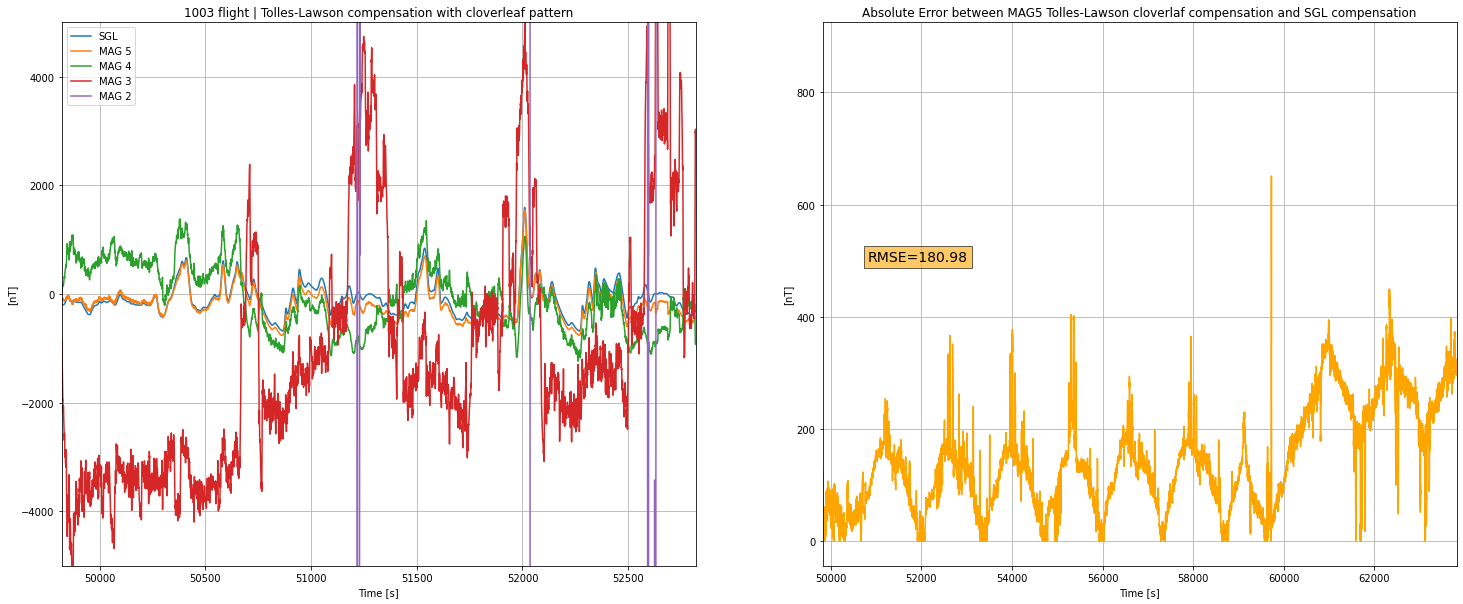

In [88]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[25,10])

ax1.plot(df_chall['IGRFMAG1'],label='SGL')
ax1.plot(df_chall['TL_comp_mag5_cl']-np.mean(df_chall['TL_comp_mag5_cl']),label='MAG 5')
ax1.plot(df_chall['TL_comp_mag4_cl']-np.mean(df_chall['TL_comp_mag4_cl']),label='MAG 4')
ax1.plot(df_chall['TL_comp_mag3_cl']-np.mean(df_chall['TL_comp_mag3_cl']),label='MAG 3')
ax1.plot(df_chall['TL_comp_mag2_cl']-np.mean(df_chall['TL_comp_mag2_cl']),label='MAG 2')

ax1.axes.set_xlim(df_chall.index[0],df_chall.index[0]+3000)
ax1.axes.set_ylim(-5000,5000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.set_title('1003 flight | Tolles-Lawson compensation with cloverleaf pattern')
ax1.legend()
ax1.grid()

rmse_sgl_mag5tlcl = magnav.rmse(df_chall['TL_comp_mag5_cl'],df_chall['IGRFMAG1'])

ax2.plot(np.sqrt((df_chall['IGRFMAG1']-(df_chall['TL_comp_mag5_cl']-np.mean(df_chall['TL_comp_mag5_cl'])))**2),c='orange')

ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.axes.set_xlim(df_chall.index[0],df_chall.index[0]+14000)
ax2.set_title('Absolute Error between MAG5 Tolles-Lawson cloverlaf compensation and SGL compensation')
ax2.grid()
plt.text(df_chall.index[0]+1000,500,f'RMSE={rmse_sgl_mag5tlcl:.2f}',fontsize=14,bbox=dict(facecolor = 'orange',alpha=0.6))

plt.show()

### 4.3.3 - Square+Cloverleaf pattern

In [35]:
fs      = 10.0
lowcut  = 0.1
highcut = 0.9
filt    = ['Butterworth',4]

# Combine SQ and CL patterns
tl_sqcl = df_pattern[mask_1+mask_2]

# Create Tolles-Lawson coefficients
TL_coef_1 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG1'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_2 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG2'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_3 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG3'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_4 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG4'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)
TL_coef_5 = magnav.create_TL_coef(tl_sqcl['FLUXB_X'],tl_sqcl['FLUXB_Y'],tl_sqcl['FLUXB_Z'],tl_sqcl['UNCOMPMAG5'],
                           lowcut=lowcut,highcut=highcut,fs=fs,filter_params=filt)

# Create Tolles-Lawson A matrix
A = magnav.create_TL_A(df_chall['FLUXB_X'],df_chall['FLUXB_Y'],df_chall['FLUXB_Z'])

# Correct magnetometers measurements
TL_comp_mag1_sqcl = np.reshape(df['UNCOMPMAG1'].tolist(),(-1,1))-np.dot(A,TL_coef_1)+np.mean(np.dot(A,TL_coef_1))
df_chall['TL_comp_mag2_sqcl'] = np.reshape(df_chall['UNCOMPMAG2'].tolist(),(-1,1))-np.dot(A,TL_coef_2)+np.mean(np.dot(A,TL_coef_2))
df_chall['TL_comp_mag3_sqcl'] = np.reshape(df_chall['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
df_chall['TL_comp_mag4_sqcl'] = np.reshape(df_chall['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
df_chall['TL_comp_mag5_sqcl'] = np.reshape(df_chall['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))

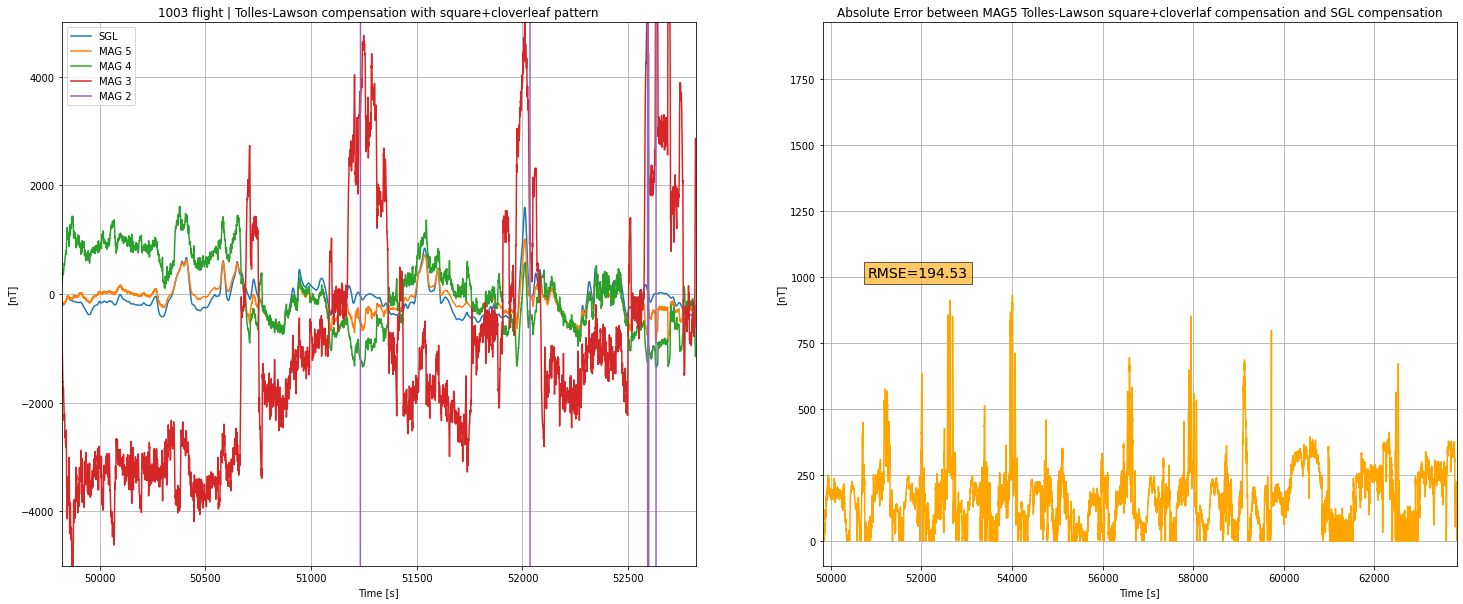

In [89]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[25,10])

ax1.plot(df_chall['IGRFMAG1'],label='SGL')
ax1.plot(df_chall['TL_comp_mag5_sqcl']-np.mean(df_chall['TL_comp_mag5_sqcl']),label='MAG 5')
ax1.plot(df_chall['TL_comp_mag4_sqcl']-np.mean(df_chall['TL_comp_mag4_sqcl']),label='MAG 4')
ax1.plot(df_chall['TL_comp_mag3_sqcl']-np.mean(df_chall['TL_comp_mag3_sqcl']),label='MAG 3')
ax1.plot(df_chall['TL_comp_mag2_sqcl']-np.mean(df_chall['TL_comp_mag2_sqcl']),label='MAG 2')

ax1.axes.set_xlim(df_chall.index[0],df_chall.index[0]+3000)
ax1.axes.set_ylim(-5000,5000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('[nT]')
ax1.set_title('1003 flight | Tolles-Lawson compensation with square+cloverleaf pattern')
ax1.legend()
ax1.grid()

rmse_sgl_mag5tlsqcl = magnav.rmse(df_chall['TL_comp_mag5_sqcl'],df_chall['IGRFMAG1'])

ax2.plot(np.sqrt((df_chall['IGRFMAG1']-(df_chall['TL_comp_mag5_sqcl']-np.mean(df_chall['TL_comp_mag5_sqcl'])))**2),c='orange')

ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[nT]')
ax2.axes.set_xlim(df_chall.index[0],df_chall.index[0]+14000)
ax2.set_title('Absolute Error between MAG5 Tolles-Lawson square+cloverlaf compensation and SGL compensation')
ax2.grid()
plt.text(df_chall.index[0]+1000,1000,f'RMSE={rmse_sgl_mag5tlsqcl:.2f}',fontsize=14,bbox=dict(facecolor = 'orange',alpha=0.6))

plt.show()

# 5 - Feature selection

Histograms plots

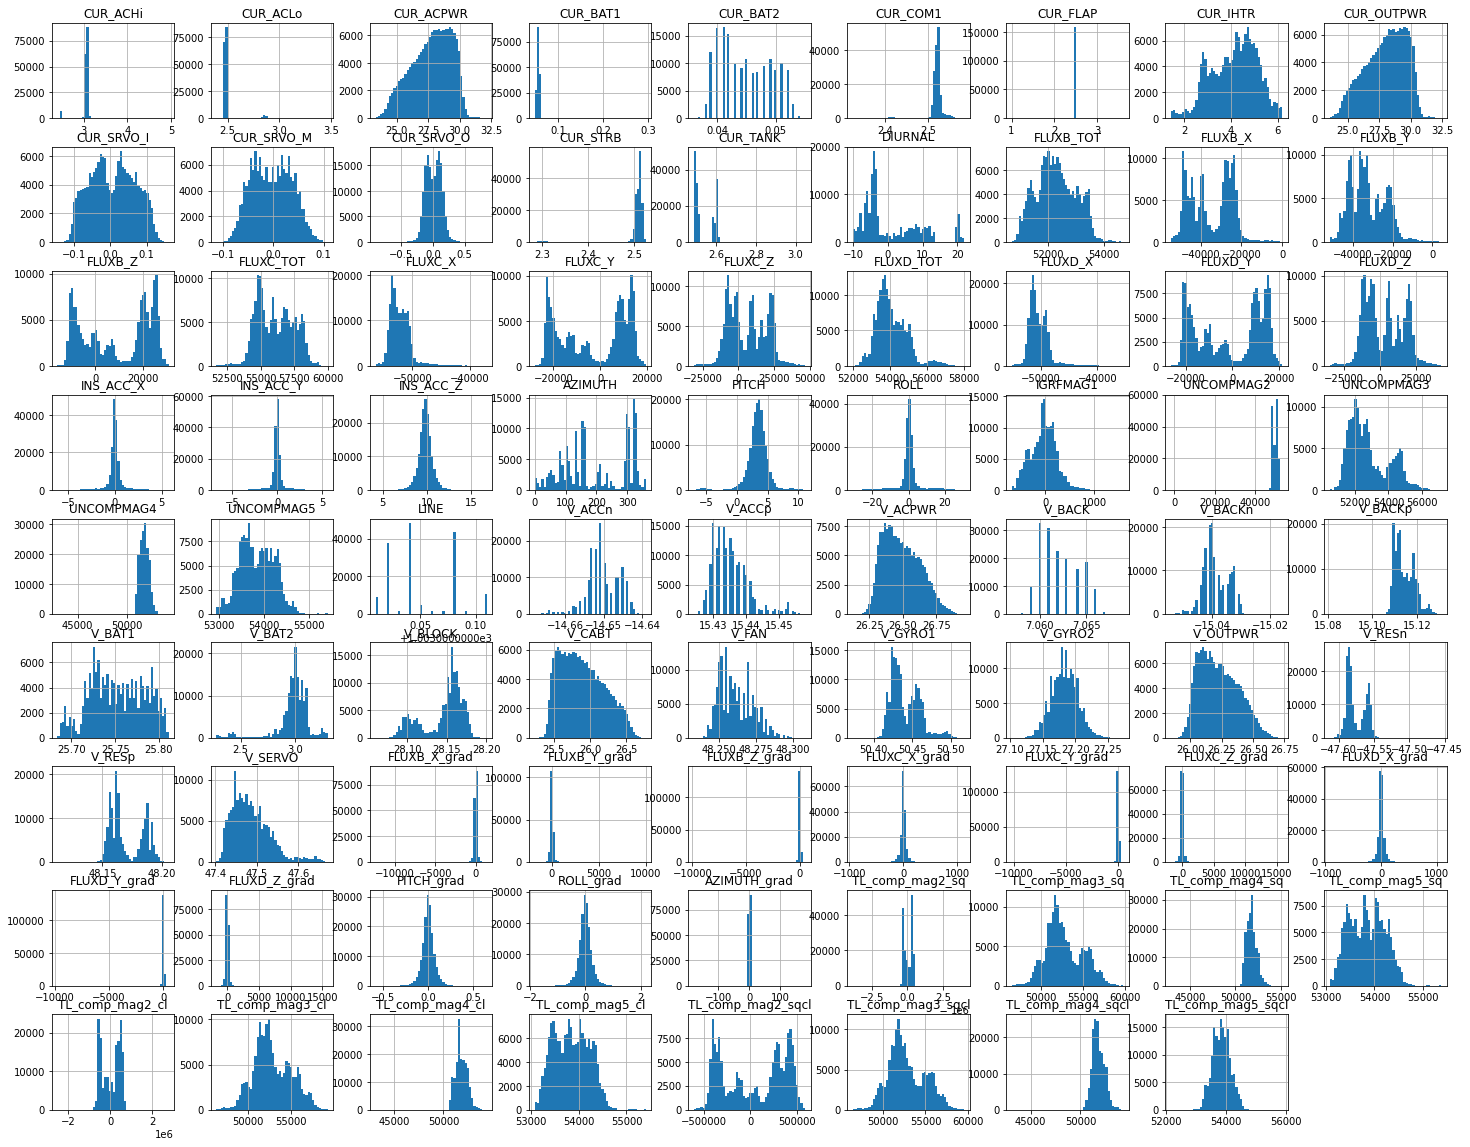

In [37]:
df_chall.hist(bins=50,figsize=[25,20])
plt.show()

## 5.1 - Main feature selection

### 5.1.1 - Correlation

In [38]:
corr_sglcomp = df_chall.drop(columns=['LINE']).corr()[['IGRFMAG1']].abs().sort_values(by='IGRFMAG1',ascending=False)
corr_sglcomp_spearman = df_chall.drop(columns=['LINE']).corr(method='spearman')[['IGRFMAG1']].abs().sort_values(by='IGRFMAG1',ascending=False)

corr_sglcomp = corr_sglcomp.drop('IGRFMAG1')
corr_sglcomp_spearman = corr_sglcomp_spearman.drop('IGRFMAG1')



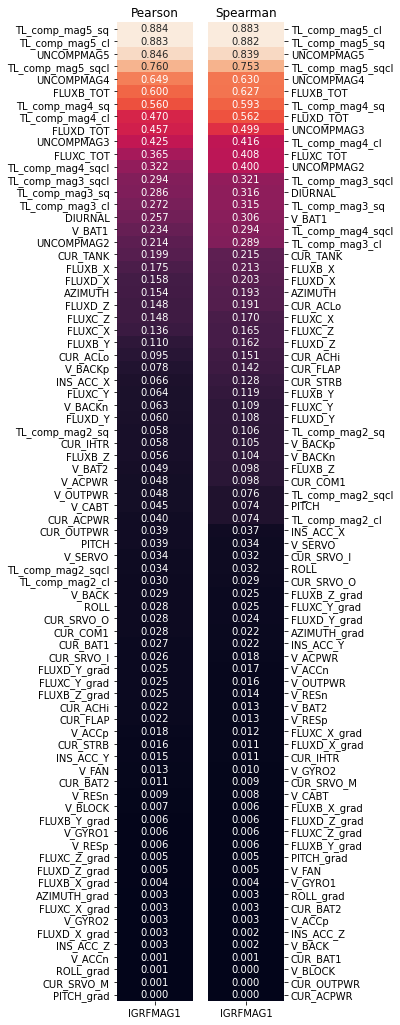

In [60]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[3,18])

df_corr_htmap = sns.heatmap(corr_sglcomp,annot=True,fmt=".3f",ax=ax1,cbar=False)
df_corr_htmap_spear = sns.heatmap(corr_sglcomp_spearman,annot=True,fmt=".3f",ax=ax2,cbar=False)

df_corr_htmap_spear.set_title('Spearman')
df_corr_htmap.set_title('Pearson')
df_corr_htmap_spear.yaxis.tick_right()
df_corr_htmap_spear.set_yticklabels(df_corr_htmap_spear.get_yticklabels(),rotation=0)
plt.show()

### 5.1.2 - Mutual informations

In [40]:
non_float = np.sum(df_chall.dtypes == int)
print(f"Number of non float value : {non_float} (if different from 0, make_mi_scores don't work)")

Number of non float value : 0 (if different from 0, make_mi_scores don't work)


In [41]:
def make_mi_scores(X,y,n_neighbors=3):
    
    mi_scores = mutual_info_regression(X,y,n_neighbors=n_neighbors)
    mi_scores = pd.Series(mi_scores, name = 'Mutual Informations scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

def plot_mi_scores(scores):
    
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.grid()
    plt.title("Mutual Information Scores")

In [42]:
mi_scores = make_mi_scores(df_chall.drop(columns=['IGRFMAG1']),df_chall['IGRFMAG1'],n_neighbors=5)

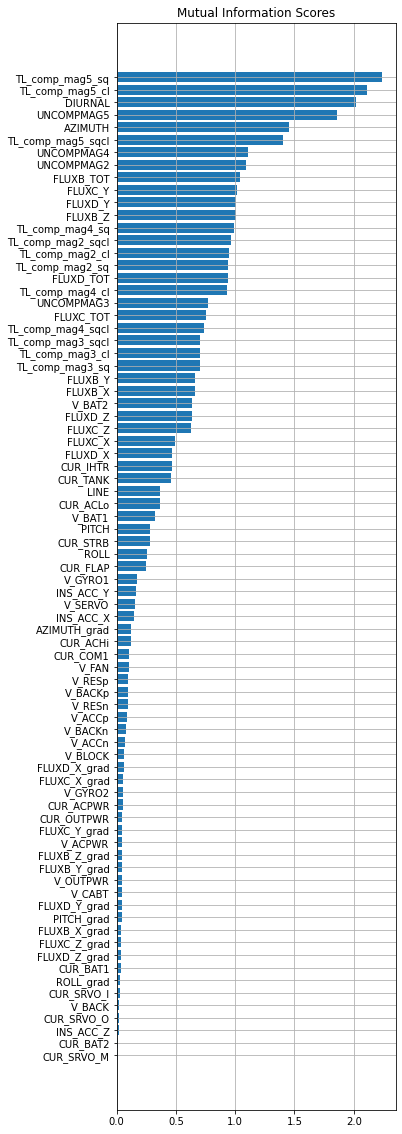

In [43]:
fig, ax = plt.subplots(figsize=[5,20])
plot_mi_scores(mi_scores)

### 5.1.3 - PCA

In [44]:
def plot_variance(pca,width=8):
    fig, axs = plt.subplots(1,2)
    n = pca.n_components_
    grid = np.arange(1,n+1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel='Component',title='% Explained Variance', ylim=(0.0,1.0))
    
    # Cumulative variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0,grid],np.r_[0,cv],"o-")
    axs[1].set(xlabel='Component',title='% Cumulative Variance', ylim=(0.0,1.0))
    
    fig.set(figwidth=width)

Number of components needed to explain 90.0% of variance: 21



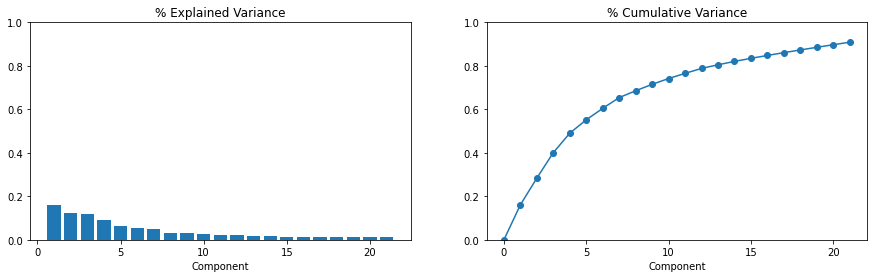

In [45]:
df_chall_scaled = (df_chall.drop(columns=['LINE','IGRFMAG1'])-df_chall.drop(columns=['LINE','IGRFMAG1']).mean(axis=0))/df_chall.drop(columns=['LINE','IGRFMAG1']).std(axis=0)

var = 0.90
pca = PCA(n_components = var)
pca.fit(df_chall_scaled)

components = len(pca.explained_variance_ratio_*100)
print(f'Number of components needed to explain {var*100}% of variance: {components}\n')

plot_variance(pca,width=15)

In [46]:
print('=============================================================================================')
print('|                     Top 5 most important features in each component                       |')
print('=============================================================================================')

pca_components = abs(pca.components_)
for row in range(pca_components.shape[0]):
    temp = np.argpartition(-(pca_components[row]),5)
    indices = temp[np.argsort((-pca_components[row])[temp])][:5]
    print(f'Component {row}: {df_chall_scaled.columns[indices].to_list()}')

|                     Top 5 most important features in each component                       |
Component 0: ['FLUXC_Z', 'FLUXD_Z', 'FLUXB_Y', 'FLUXC_TOT', 'UNCOMPMAG3']
Component 1: ['TL_comp_mag2_sqcl', 'TL_comp_mag2_sq', 'TL_comp_mag2_cl', 'FLUXD_Y', 'FLUXB_Z']
Component 2: ['UNCOMPMAG5', 'UNCOMPMAG4', 'TL_comp_mag5_sqcl', 'TL_comp_mag5_sq', 'TL_comp_mag5_cl']
Component 3: ['TL_comp_mag4_sq', 'TL_comp_mag5_sq', 'UNCOMPMAG4', 'TL_comp_mag5_cl', 'TL_comp_mag5_sqcl']
Component 4: ['FLUXC_Z_grad', 'FLUXD_Z_grad', 'FLUXB_Y_grad', 'ROLL_grad', 'FLUXB_X_grad']
Component 5: ['CUR_BAT1', 'V_BACKp', 'V_GYRO1', 'CUR_IHTR', 'V_SERVO']
Component 6: ['FLUXB_Z_grad', 'FLUXD_Y_grad', 'FLUXC_Y_grad', 'PITCH_grad', 'INS_ACC_X']
Component 7: ['FLUXC_X_grad', 'FLUXD_X_grad', 'CUR_SRVO_M', 'FLUXB_X_grad', 'V_BAT2']
Component 8: ['V_BAT2', 'V_GYRO2', 'V_ACCp', 'V_BACKn', 'FLUXD_X_grad']
Component 9: ['V_ACCn', 'V_BACKn', 'V_FAN', 'INS_ACC_X', 'V_RESp']
Component 10: ['INS_ACC_X', 'FLUXD_X', 'FLUXC_X', 'V_G

In [47]:
df_chall_PCA = pca.transform(df_chall_scaled)

## 5.2 - Searching for other useful data

Creation residue between true and mags

In [48]:
scaler = MinMaxScaler(feature_range=(-1,1))

df_corr = pd.DataFrame()

# Residue between uncomp mags and true - no rescale 
df_corr['res_MAG5'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG5'])
df_corr['res_MAG4'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG4'])
df_corr['res_MAG3'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG3'])
df_corr['res_MAG2'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['UNCOMPMAG2'])

# Residue between uncomp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG5'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG4'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG3'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc'] = scaler.transform(np.reshape(df_corr['res_MAG2'].tolist(),(-1,1)))

# Residue between TL square pattern comp mags and true - no rescale
df_corr['res_MAG5_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag5_sq'])
df_corr['res_MAG4_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag4_sq'])
df_corr['res_MAG3_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag3_sq'])
df_corr['res_MAG2_tlsq'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag2_sq'])

# Residue between TL square pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlsq'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlsq'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlsq'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlsq'].tolist(),(-1,1)))

# Residue between TL cloverleaf pattern comp mags and true - no rescale
df_corr['res_MAG5_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag5_cl'])
df_corr['res_MAG4_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag4_cl'])
df_corr['res_MAG3_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag3_cl'])
df_corr['res_MAG2_tlcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag2_cl'])

# Residue between TL cloverleaf pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlcl'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlcl'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlcl'].tolist(),(-1,1)))

# Residue between TL square+cloverleaf pattern comp mags and true - no rescale
df_corr['res_MAG5_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag5_sqcl'])
df_corr['res_MAG4_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag4_sqcl'])
df_corr['res_MAG3_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag3_sqcl'])
df_corr['res_MAG2_tlsqcl'] = df_chall['IGRFMAG1']-signal.detrend(df_chall['TL_comp_mag2_sqcl'])


# Residue between TL square+cloverleaf pattern comp mags and true - [-1,1] rescale
scaler.fit(np.reshape(df_corr['res_MAG5_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG5_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG5_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG4_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG4_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG4_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG3_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG3_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG3_tlsqcl'].tolist(),(-1,1)))
scaler.fit(np.reshape(df_corr['res_MAG2_tlsqcl'].tolist(),(-1,1)))
df_corr['res_MAG2_rsc_tlsqcl'] = scaler.transform(np.reshape(df_corr['res_MAG2_tlsqcl'].tolist(),(-1,1)))

In [49]:
variables = ['CUR_ACHi', 'CUR_ACLo', 'CUR_ACPWR', 'CUR_BAT1', 'CUR_BAT2', 'CUR_COM1',
       'CUR_FLAP', 'CUR_IHTR', 'CUR_OUTPWR', 'CUR_SRVO_I', 'CUR_SRVO_M',
       'CUR_SRVO_O', 'CUR_STRB', 'CUR_TANK', 'DIURNAL', 'FLUXB_TOT', 'FLUXB_X',
       'FLUXB_Y', 'FLUXB_Z', 'FLUXC_TOT', 'FLUXC_X', 'FLUXC_Y', 'FLUXC_Z',
       'FLUXD_TOT', 'FLUXD_X', 'FLUXD_Y', 'FLUXD_Z', 'INS_ACC_X', 'INS_ACC_Y',
       'INS_ACC_Z', 'AZIMUTH', 'PITCH', 'ROLL','V_ACCn', 'V_ACCp',
       'V_ACPWR', 'V_BACK', 'V_BACKn', 'V_BACKp', 'V_BAT1', 'V_BAT2',
       'V_BLOCK', 'V_CABT', 'V_FAN', 'V_GYRO1', 'V_GYRO2', 'V_OUTPWR',
       'V_RESn', 'V_RESp', 'V_SERVO', 'FLUXB_X_grad', 'FLUXB_Y_grad',
       'FLUXB_Z_grad', 'FLUXC_X_grad', 'FLUXC_Y_grad', 'FLUXC_Z_grad',
       'FLUXD_X_grad', 'FLUXD_Y_grad', 'FLUXD_Z_grad', 'PITCH_grad',
       'ROLL_grad', 'AZIMUTH_grad']
residues_list = ['res_MAG5','res_MAG4','res_MAG3','res_MAG2','res_MAG5_rsc',
                 'res_MAG4_rsc','res_MAG3_rsc','res_MAG2_rsc','res_MAG5_tlsq',
                 'res_MAG4_tlsq','res_MAG3_tlsq', 'res_MAG2_tlsq', 'res_MAG5_rsc_tlsq',
                 'res_MAG4_rsc_tlsq','res_MAG3_rsc_tlsq','res_MAG2_rsc_tlsq',
                 'res_MAG5_tlcl','res_MAG4_tlcl','res_MAG3_tlcl','res_MAG2_tlcl',
                 'res_MAG5_rsc_tlcl','res_MAG4_rsc_tlcl','res_MAG3_rsc_tlcl',
                 'res_MAG2_rsc_tlcl','res_MAG5_tlsqcl','res_MAG4_tlsqcl',
                 'res_MAG3_tlsqcl','res_MAG2_tlsqcl','res_MAG5_rsc_tlsqcl',
                 'res_MAG4_rsc_tlsqcl','res_MAG3_rsc_tlsqcl','res_MAG2_rsc_tlsqcl']
df_corr[variables] = df_chall[variables]
corr_residues = df_corr.corr()
corr_residues = corr_residues.drop(columns=variables)
corr_residues = corr_residues.drop(residues_list)

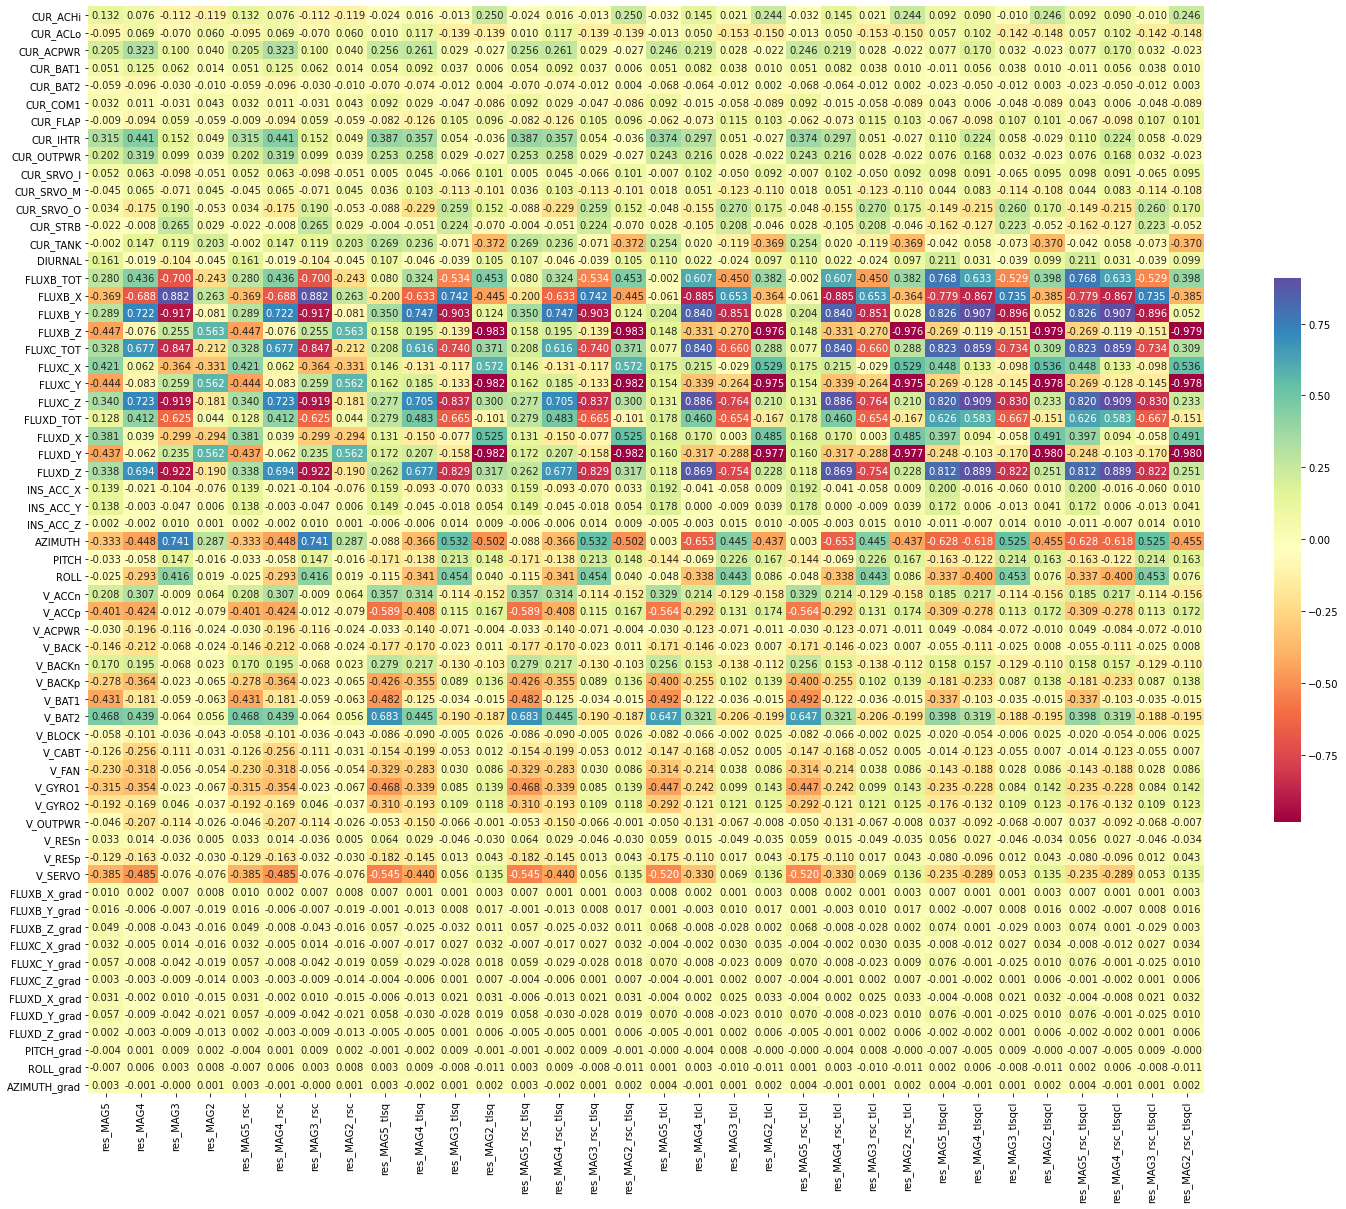

In [50]:
fig, ax = plt.subplots(figsize=[25,20])

df_corr_htmap = sns.heatmap(corr_residues,annot=True,fmt=".3f",ax=ax,cmap="Spectral",cbar_kws={"shrink":.5})
plt.show()

## 5.3 - Pre-Selected features

In [51]:
features = ['TL_comp_mag5_sq','DIURNAL','UNCOMPMAG5','AZIMUTH','UNCOMPMAG4','UNCOMPMAG2','FLUXB_TOT','FLUXC_Y','UNCOMPMAG3'] # Mi score > 1 ou corr > 0.4
features = features + ['V_BAT2','V_SERVO','V_BAT1','V_ACCp','ROLL'] # Correlation with residue > 0.45

# 6 - Dataset

## 6.1 - Challenge solution Dataset

In [93]:
for n in tqdm(range(2,6)):
    
    df = pd.read_hdf('../data/interim/Flt_data.h5', key=f'Flt100{n}')
    
    calcIGRF = df['DCMAG1']-df['IGRFMAG1'] 
    
    A = magnav.create_TL_A(df['FLUXB_X'],df['FLUXB_Y'],df['FLUXB_Z'])
    
    df['TL_comp_mag3_sq'] = np.reshape(df['UNCOMPMAG3'].tolist(),(-1,1))-np.dot(A,TL_coef_3)+np.mean(np.dot(A,TL_coef_3))
    df['TL_comp_mag4_sq'] = np.reshape(df['UNCOMPMAG4'].tolist(),(-1,1))-np.dot(A,TL_coef_4)+np.mean(np.dot(A,TL_coef_4))
    df['TL_comp_mag5_sq'] = np.reshape(df['UNCOMPMAG5'].tolist(),(-1,1))-np.dot(A,TL_coef_5)+np.mean(np.dot(A,TL_coef_5))
    
    df['TL_comp_mag3_sq'] = df['TL_comp_mag3_sq']-df['DIURNAL']-calcIGRF
    df['TL_comp_mag4_sq'] = df['TL_comp_mag4_sq']-df['DIURNAL']-calcIGRF
    df['TL_comp_mag5_sq'] = df['TL_comp_mag5_sq']-df['DIURNAL']-calcIGRF
    
    df_sol = df[['FLUXB_TOT','FLUXB_X','FLUXC_TOT','FLUXC_Y','FLUXD_Y','FLUXD_Z','TL_comp_mag3_sq',
                 'UNCOMPMAG3','TL_comp_mag4_sq','TL_comp_mag5_sq','V_CABT','LINE','IGRFMAG1']]
    
    # export to HDF5
    df_sol.to_hdf(f'../data/interim/Sol_dataset.h5',key=f'Flt100{n}')
    # export to csv
    df_sol.to_csv(f'../data/interim/Sol_dataset_csv/Flt100{n}.csv')

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]


In [52]:
df_sol = df_chall[['FLUXB_TOT','FLUXB_X','FLUXC_TOT','FLUXC_Y','FLUXD_Y','FLUXD_Z','TL_comp_mag3_sq','UNCOMPMAG3','TL_comp_mag4_sq','TL_comp_mag5_sq','V_CABT','LINE']]
df_sol.head()

# export to HDF5
df_sol.to_hdf('../data/interim/Sol_dataset.h5',key='Flt1003')
# export to csv
df_sol.to_csv(f'../data/interim/Sol_dataset_csv/Flt1003.csv')